# Projekt: Bild-Klassifikator für eigene Objekte

In [10]:
# Import Libraries
# import libraries
# from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential,Input,Model

import numpy as np
import matplotlib.pyplot as plt

## Phase 1: Datensammlung

Es wurden Bilder der Klassen Bottle, Cup, Keyboard und Pen gesammelt.
Im ersten Schritt wurden die Bilder mithilfe des [Normalize Notebook](normalize.ipynb) normalisiert, um ihre Größe lokal zu reduzieren und sie anschließend effizient auf GitHub hochzuladen.

## Phase 2: Datenverarbeitung & Exploration

- Bottle
- Cup
- Keyboard
- Pen

### Lade die Bilder und verschaffe dir einen Überblick:

In [11]:
img = image.load_img('dataset/train/bottle/IMG_2646.jpg')
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [12]:
#convert image to array, can also specify datatype
img = image.img_to_array(img,dtype='uint8')

In [13]:
img.shape

(224, 224, 3)

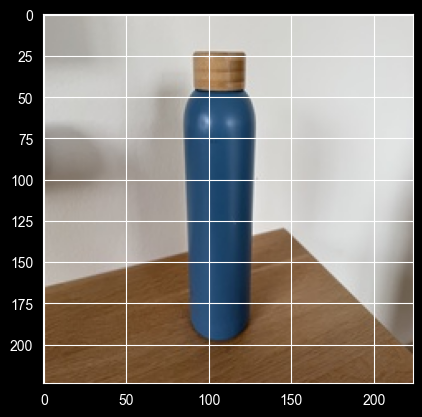

In [14]:
#plot image 
plt.imshow(img)

### Loading the entire images and labels

In [15]:
# Let's explore the data folder
import os
base_path = 'dataset/train/'

# Let's define the classes
classes = os.listdir(base_path)

In [16]:
 for class_ in classes:
        print(class_)

cup
pen
bottle
keyboard


In [17]:
def load_image(base_path):
    """it loads all the image into X and the classes in y """
    X_list = []
    y_list = []
    classes = os.listdir(base_path)
    for class_ in classes:
        if class_!='.DS_Store':
        
            files = os.listdir(base_path+class_)
            for file in files:
                pic = image.load_img(path=base_path+class_+'/'+f'{file}',target_size=(224,224))
                numpy_image = np.array(pic)
                processed_image = preprocess_input(numpy_image)
                X_list.append(processed_image)
                y_list.append(class_)

    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y, classes

In [18]:
X, y, classes= load_image(base_path)

In [19]:
X.shape

(280, 224, 224, 3)

In [20]:
y

array(['cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup',
       'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen', 'pen',
       'pen', 'pen',

## Implementiere Preprocessing:

In [21]:
X = preprocess_input(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


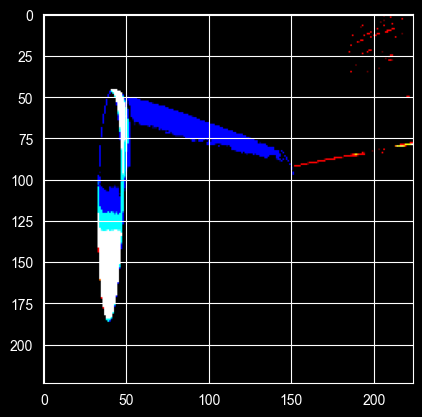

In [23]:
plt.imshow(X[0])

## Richte Data Augmentation ein:

In [35]:
# define an image data generator
# Data augmentation: Applies random distortions and transformations to the images (only on your training data!).

data_gen = image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=preprocess_input,
    # fill_mode='nearest',
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=(1.1, 1.2),
    # shear_range=0.2
)

In [43]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory='dataset/train',
        class_mode="categorical",
        classes=classes,
        batch_size=300,
        target_size=(224, 224),
)

Found 280 images belonging to 4 classes.


In [44]:
train_data_gen.class_indices

{'cup': 0, 'pen': 1, 'bottle': 2, 'keyboard': 3}

In [45]:
train_data_gen.samples

280

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


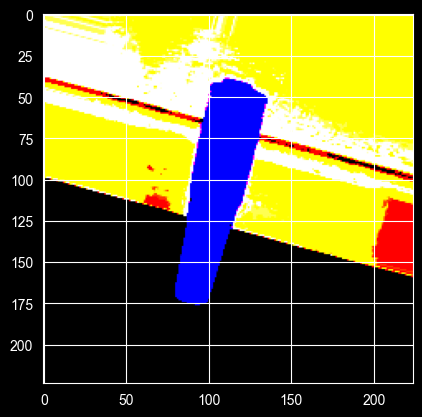

In [42]:
batch_bilder, batch_labels = train_data_gen[1]

image_to_show = batch_bilder[1]

plt.imshow(image_to_show)

## Phase 3: Modelltraining mit Transfer Learning

# Wähle ein vortrainiertes Modell als Basis:

## Phase 4: Evaluation

## Phase 5: Testing mit neuen Bildern